In [1]:
import os
import pandas as pd
import numpy as np
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
import tensorflow_addons as tfa
import cv2

from sklearn import model_selection
from PIL import Image
from skimage import exposure

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import models
from tensorflow.keras import layers
from imblearn.over_sampling import SMOTE

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# Datos

## Datos

In [3]:
path = '/home/mr1142/Documents/Data/covid/dataset'

In [4]:
covid = [os.path.join(path, 'covid', p) for p in os.listdir(os.path.join(path, 'covid'))]
normal = [os.path.join(path, 'normal', p) for p in os.listdir(os.path.join(path, 'normal'))]

In [5]:
df = pd.DataFrame()
df['path'] = covid + normal
df['covid'] = [1 for i in range(len(covid))] + [0 for i in range(len(normal))]

In [6]:
df = df.sample(frac=1)

In [7]:
df.head()

,path,covid
55,/home/mr1142/Documents/Data/covid/dataset/norm...,0
4,/home/mr1142/Documents/Data/covid/dataset/covi...,1
13,/home/mr1142/Documents/Data/covid/dataset/covi...,1
51,/home/mr1142/Documents/Data/covid/dataset/norm...,0
12,/home/mr1142/Documents/Data/covid/dataset/covi...,1


In [8]:
len(df)

59

In [9]:
print(len(df[df.covid == 1]))
print(len(df[df.covid == 0]))

38
21


## Imagenes

In [10]:
pixels = 512

In [11]:
def charge_reshape(path, pix):
    img = Image.open(path)
    img = img.resize((pix,pix))
    img = np.array(img)
    try:
        img = img[:,:,0]
    except:
        print('e')
    img = clahe(img)
    img = np.expand_dims(img, axis=-1)
    img = img/255
    return img

In [12]:
def clahe(img):
    # img = cv2.resize(img, (512, 512))
    clahe = cv2.createCLAHE(clipLimit = 10)
    final_img = clahe.apply(img) + 30
    return final_img

In [13]:
tensor = np.zeros((len(df.path), pixels, pixels, 1))
for i in range(tensor.shape[0]):
    p = os.path.join(path, df.path[i])
    tensor[i,...] = charge_reshape(p, pixels)

e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e


## X e Y

In [14]:
Y = np.array(df['covid'])
X = tensor

In [15]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, 
                                                                    random_state=42, shuffle=True, stratify=Y )

## Oversample con SMOTE

In [16]:
X_train.shape

(47, 512, 512, 1)

Te pide dos dimensiones, por lo que hay que transformar

In [17]:
ReX_train = X_train.reshape(47, 512 * 512)
ReX_train.shape

(47, 262144)

In [18]:
smt = SMOTE()
Xs_train, Ys_train = smt.fit_resample(ReX_train, Y_train)

In [19]:
Xs_train.shape

(60, 262144)

Volvemos a transformarlo para las dimensiones normales

In [20]:
Xs_train = Xs_train.reshape(60, 512, 512, 1)

In [21]:
print(len(Xs_train))

60


### Generación de imagenes

In [22]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

In [23]:
datagen.fit(X_train)

# Modelo

- Añado una capa inicial para poder entregarle el input de 3 canales. 
- Añado 1 convolución con max pooling y una segunda convolución cno globalMaxPooling para ajustar mejor
- Añado Dropout para evitar overfiting
- Añado la capa final con 6 neuronas de salida

In [24]:
input_shape = (pixels,pixels,3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)

In [25]:
len(conv_base.layers)

237

In [26]:
len(conv_base.trainable_variables)

211

In [27]:
model = models.Sequential()
model.add(layers.Conv2D(3,3,padding="same", input_shape=(pixels,pixels,1), activation='elu', name = 'conv_inicial'))
model.add(conv_base)
model.add(layers.Conv2D(3,32, padding='same', input_shape=(8,8,1280), activation='selu', name = 'conv_posterior'))
model.add(layers.MaxPool2D(pool_size = (2,2), padding='same', name = 'first_pooling'))
model.add(layers.Conv2D(3,64, padding='same', input_shape=(4,4,1280), activation='selu', name = 'last_convolution'))
model.add(layers.GlobalMaxPooling2D(name="general_max_pooling"))
model.add(layers.Dropout(0.2, name="dropout_out"))
model.add(layers.Dense(1, activation="softmax", name="fc_out"))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_inicial (Conv2D)        (None, 512, 512, 3)       30        
_________________________________________________________________
efficientnetb0 (Functional)  (None, 16, 16, 1280)      4049571   
_________________________________________________________________
conv_posterior (Conv2D)      (None, 16, 16, 3)         3932163   
_________________________________________________________________
first_pooling (MaxPooling2D) (None, 8, 8, 3)           0         
_________________________________________________________________
last_convolution (Conv2D)    (None, 8, 8, 3)           36867     
_________________________________________________________________
general_max_pooling (GlobalM (None, 3)                 0         
_________________________________________________________________
dropout_out (Dropout)        (None, 3)                 0

# Compilación y entrenamiento

## Callback

In [29]:
log_dir = "/home/mr1142/Documents/Data/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      update_freq='batch',
                                                      histogram_freq=1)

## 1º entrenamiento
Solo vamos a entrenar las capas que hemos añadido

In [30]:
conv_base.trainable = False

In [31]:
len(model.trainable_variables)

8

### Hiperparámetros

1. **Loss**

In [32]:
loss = tf.keras.losses.BinaryCrossentropy()

2. **Optimizador y learning rate**

In [33]:
lr = 0.001
opt = tf.keras.optimizers.Adam(learning_rate = lr)

3. **Metricas**

In [34]:
met = ['BinaryAccuracy', 'TruePositives']

4. **Batch size**

In [39]:
batch = 8

5. **Epochs**

In [40]:
initial_epochs = 50

### Entrenamiento

In [41]:
model.compile(optimizer=opt, loss = loss , metrics = met)

Las imagenes se generan en cada batch, por eso hay que añadir aqui el datagen. Así no ocupa más en memoria

In [43]:
history = model.fit(datagen.flow(Xs_train,Ys_train, subset = 'training', batch_size = batch),
                    epochs = initial_epochs,
                    callbacks = tensorboard_callback,
                    validation_data = (X_test, Y_test))

Epoch 1/50
6/6 [==============================] - 297s 21s/step - loss: 0.7374 - binary_accuracy: 0.3494 - true_positives: 12.1429 - val_loss: 0.6808 - val_binary_accuracy: 0.6667 - val_true_positives: 8.0000
Epoch 2/50
6/6 [==============================] - 1s 130ms/step - loss: 0.7948 - binary_accuracy: 0.4339 - true_positives: 13.4286 - val_loss: 0.6723 - val_binary_accuracy: 0.6667 - val_true_positives: 8.0000
Epoch 3/50
6/6 [==============================] - 1s 103ms/step - loss: 0.7528 - binary_accuracy: 0.3789 - true_positives: 13.2857 - val_loss: 0.7940 - val_binary_accuracy: 0.6667 - val_true_positives: 8.0000
Epoch 4/50
6/6 [==============================] - 1s 103ms/step - loss: 0.7327 - binary_accuracy: 0.4443 - true_positives: 13.7143 - val_loss: 0.7098 - val_binary_accuracy: 0.6667 - val_true_positives: 8.0000
Epoch 5/50
6/6 [==============================] - 1s 102ms/step - loss: 0.7019 - binary_accuracy: 0.4283 - true_positives: 13.1429 - val_loss: 0.6857 - val_binary_a

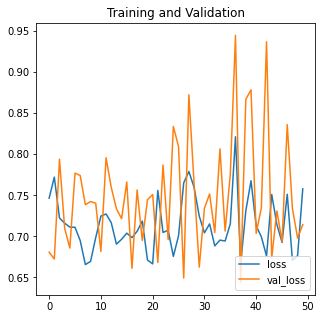

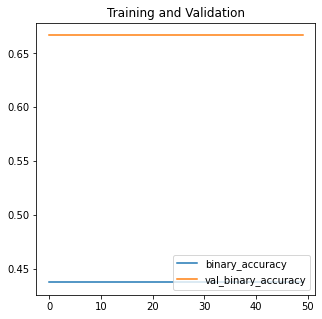

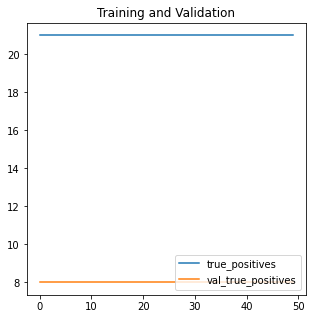

In [44]:
epochs_range = range(initial_epochs)
i = 0
for i in range(int(len(history.history.keys())/2)):
    key = list(history.history.keys())[i]
    
    plt.figure(figsize=(5, 5))
    plt.subplot(1, 1, 1)
    plt.plot(epochs_range, history.history[key], label=key)
    plt.plot(epochs_range, history.history['val_' + key], label='val_' + key)
    plt.legend(loc='lower right')
    plt.title('Training and Validation')
plt.show()

## 2º Entrenamiento
Ahora vamos a entrenar tambien la red preentrenada, pero no queremos entrenar todas las capas, únicamente las capas más profundas, ya que las primeras capas son muy genéricas.

### Ajustar el entrenamiento de la red preentrenada

In [45]:
conv_base.trainable = True

In [46]:
len(conv_base.layers)

237

Vamos a entrenar desde la capa 100

In [47]:
fine_tune_at = 100

for layer in conv_base.layers[:fine_tune_at]:
    layer.trainable = False

In [48]:
len(model.trainable_variables)

131

## Hiperparámetros
Como el modelo es mucho más grande tenemos que usar un learning rate más bajo del que usabamos.
Vamos a utilizar dos learning rates, uno para el modelo preentrenado y otro para las capas nuevas

In [49]:
opt = [tf.keras.optimizers.Adam(learning_rate = lr), tf.keras.optimizers.RMSprop(learning_rate = lr/10)]
optimizers_and_layers = [(opt[0], model.layers[0]),
                         (opt[1], model.layers[1]),
                         (opt[0], model.layers[2:])]
opt = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

In [50]:
batch_size = 4
fine_tune_epochs = 100
total_epoch = initial_epochs + fine_tune_epochs

### Entrenamiento

In [51]:
model.compile(optimizer=opt, loss = loss , metrics = met)

In [52]:
history = model.fit(datagen.flow(Xs_train,Ys_train, subset = 'training', batch_size = batch_size), 
                    epochs = total_epoch,
                    initial_epoch=history.epoch[-1],
                    callbacks = tensorboard_callback,
                    validation_data = (X_test, Y_test))

Epoch 50/150
12/12 [==============================] - 48s 233ms/step - loss: 68.4408 - binary_accuracy: 0.4539 - true_positives: 12.2308 - val_loss: 0.8786 - val_binary_accuracy: 0.6667 - val_true_positives: 8.0000
Epoch 51/150
12/12 [==============================] - 1s 62ms/step - loss: 11.2912 - binary_accuracy: 0.4589 - true_positives: 12.6154 - val_loss: 1.3282 - val_binary_accuracy: 0.6667 - val_true_positives: 8.0000
Epoch 52/150
12/12 [==============================] - 1s 62ms/step - loss: 1.4848 - binary_accuracy: 0.3486 - true_positives: 11.2308 - val_loss: 1.5929 - val_binary_accuracy: 0.6667 - val_true_positives: 8.0000
Epoch 53/150
12/12 [==============================] - 1s 65ms/step - loss: 0.8824 - binary_accuracy: 0.4158 - true_positives: 11.7692 - val_loss: 1.7368 - val_binary_accuracy: 0.6667 - val_true_positives: 8.0000
Epoch 54/150
12/12 [==============================] - 1s 62ms/step - loss: 0.7493 - binary_accuracy: 0.3752 - true_positives: 10.5385 - val_loss: 1.

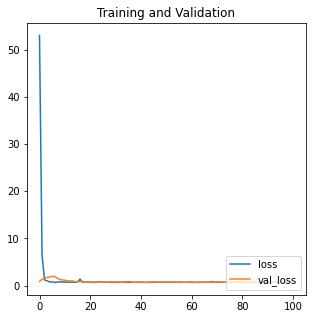

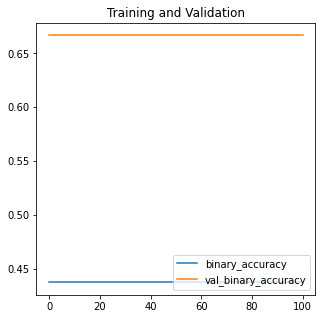

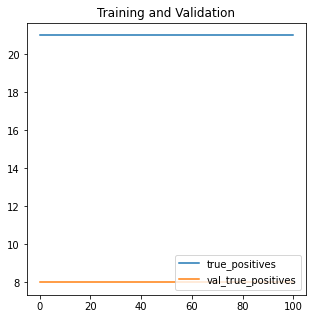

In [53]:
epochs_range = len(history.history['loss'])
i = 0
for i in range(int(len(history.history.keys())/2)):
    key = list(history.history.keys())[i]
    
    plt.figure(figsize=(5, 5))
    plt.subplot(1, 1, 1)
    plt.plot(history.history[key], label=key)
    plt.plot(history.history['val_' + key], label='val_' + key)
    plt.legend(loc='lower right')
    plt.title('Training and Validation')
plt.show()